In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import numpy as np
from scipy import stats
import seaborn as sns
from functools import reduce
pd.options.mode.chained_assignment = None 
from statistics import mean
from Profile_Generation import *
import warnings
warnings.simplefilter('ignore', np.RankWarning)

Shapiro_test p value: 0.23719334602355957
Thus, assume normality



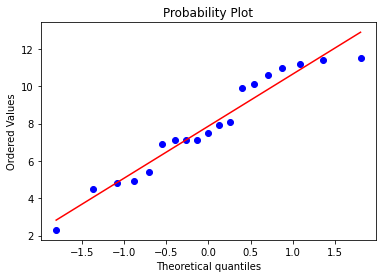

C:\Users\tshibei\AppData\Local\Temp/ipykernel_1996/3966921995.py:31: FutureWarning: Passing 'suffixes' which cause duplicate columns {'deviation_x'} in the result is deprecated and will raise a MergeError in a future version.
  df_deviation = reduce(lambda  left,right: pd.merge(left,right,on=['prediction day'],


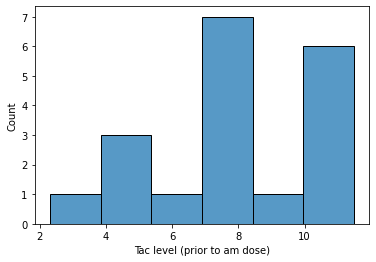

In [2]:
input_file = 'Retrospective Liver Transplant Data.xlsx'
patient_name = '120'
rows_to_skip = 17 # Number of rows to skip before reaching patient tac data

# Read individual patient data from excel, shift tac level one cell up, remove "mg" from values
df = read_indiv_patient_data(input_file, patient_name, rows_to_skip)

# Keep largest consecutive non-NA chunk of patient data
df = keep_longest_chunk(df) # If there are >1 large chunks with longest length, an error will be printed

df = df.reset_index(drop=True) 

# Perform normality test, both numerical and graphical
normality_test(df)

# Generate predictions and calculate deviations using different methods
df_Q_Cum = Q_Cum(df)
df_Q_PPM = Q_PPM(df)
df_Q_RW = Q_RW(df)
df_L_Cum = L_Cum(df)
df_L_PPM = L_PPM(df)
df_L_RW = L_RW(df)

# Create dataframe of deviation
data_frames = [df_Q_Cum[['prediction day', 'deviation']],
             df_Q_PPM[['prediction day', 'deviation']],
             df_Q_RW[['prediction day', 'deviation']],
             df_L_Cum[['prediction day', 'deviation']],
             df_L_PPM[['prediction day', 'deviation']],
             df_L_RW[['prediction day', 'deviation']]]
df_deviation = reduce(lambda  left,right: pd.merge(left,right,on=['prediction day'],
                                            how='outer'), data_frames)

# Keep rows with common prediction day
df_deviation = df_deviation.iloc[:-1,:]
df_deviation.columns = ['pred_day', 'Q_Cum', 'Q_PPM', 'Q_RW', 'L_Cum', 'L_PPM', 'L_RW']

Text(0.5, 1.0, 'RMSE and MAE of Deviation of Predicted from Actual Value')

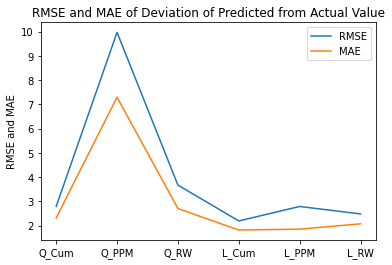

In [5]:
# Plot RMSE and MAE
df_rmse_MAE = pd.DataFrame()

## Plot RMSE
methods = ['Q_Cum', 'Q_PPM', 'Q_RW', 'L_Cum', 'L_PPM', 'L_RW']

rmse_Q_Cum = np.sqrt(mean(df_deviation['Q_Cum']**2))
rmse_Q_PPM = np.sqrt(mean(df_deviation['Q_PPM']**2))
rmse_Q_RW = np.sqrt(mean(df_deviation['Q_RW']**2))
rmse_L_Cum = np.sqrt(mean(df_deviation['L_Cum']**2))
rmse_L_PPM = np.sqrt(mean(df_deviation['Q_Cum']**2))
rmse_L_RW = np.sqrt(mean(df_deviation['L_RW']**2))

rmse = np.array([rmse_Q_Cum, rmse_Q_PPM, rmse_Q_RW, 
                rmse_L_Cum, rmse_L_PPM, rmse_L_RW])

rmse = pd.DataFrame(rmse.reshape(-1, len(rmse)),columns=methods)
rmse=rmse.transpose()

## Calculate MAE
MAE_Q_Cum = mean(abs(df_deviation['Q_Cum']))
MAE_Q_PPM = mean(abs(df_deviation['Q_PPM']))
MAE_Q_RW = mean(abs(df_deviation['Q_RW']))
MAE_L_Cum = mean(abs(df_deviation['L_Cum']))
MAE_L_PPM = mean(abs(df_deviation['L_PPM']))
MAE_L_RW = mean(abs(df_deviation['L_RW']))

MAE = np.array([MAE_Q_Cum, MAE_Q_PPM, MAE_Q_RW, 
                MAE_L_Cum, MAE_L_PPM, MAE_L_RW])

MAE = pd.DataFrame(MAE.reshape(-1, len(MAE)),columns=methods)
MAE=MAE.transpose()

df_rmse_MAE = df_rmse_MAE.append(rmse)
df_rmse_MAE = pd.concat([df_rmse_MAE, MAE], axis=1)
df_rmse_MAE.columns = ['RMSE', 'MAE']

df_rmse_MAE.plot()
plt.ylabel('RMSE and MAE')
plt.title("RMSE and MAE of Deviation of Predicted from Actual Value")
# plt.savefig('RMSE and MAE Deviation.png', bbox_inches="tight", dpi=300)

In [6]:
# Plot tac level over number of days from day 5
sub_df_120 = df_120.iloc[3:,]

plt.scatter(x = sub_df_120["Day #"], 
            y = [sub_df_120["Tac level (prior to am dose)"]])
plt.axhline(y=8, color='r', linestyle='-')
plt.axhline(y=10, color='r', linestyle='-')

df = (sub_df_120["Tac level (prior to am dose)"] > 8) & \
(sub_df_120["Tac level (prior to am dose)"] < 10)

perc_in_range = str(df.sum()) + " / " + str(sub_df_120["Tac level (prior to am dose)"].count()) + \
" x 100% = " + str(round(df.sum()/sub_df_120["Tac level (prior to am dose)"].count()*100, 1)) + "%"
perc_in_range

plt.title("Tac Level within Range")
plt.ylabel("Tac Level")
plt.xlabel("No. of Days")
plt.figtext(0.5, -0.1, "Percentage of tac level within range (from Day 5):\n" + perc_in_range, wrap=True, horizontalalignment='center', fontsize=12)

# plt.savefig('Tac Level within Range.png', bbox_inches="tight", dpi=300)

NameError: name 'df_120' is not defined

In [ ]:
# Plot tac level over number of days from day 4
sub_df_120 = df_120.iloc[2:,]

plt.scatter(x = sub_df_120["Day #"], 
            y = [sub_df_120["Tac level (prior to am dose)"]])
plt.axhline(y=8, color='r', linestyle='-')
plt.axhline(y=10, color='r', linestyle='-')

df = (sub_df_120["Tac level (prior to am dose)"] > 8) & \
(sub_df_120["Tac level (prior to am dose)"] < 10)

perc_in_range = str(df.sum()) + " / " + str(sub_df_120["Tac level (prior to am dose)"].count()) + \
" x 100% = " + str(round(df.sum()/sub_df_120["Tac level (prior to am dose)"].count()*100, 1)) + "%"
perc_in_range

plt.title("Tac Level within Range")
plt.ylabel("Tac Level")
plt.xlabel("No. of Days")
plt.figtext(0.5, -0.1, "Percentage of tac level within range (from Day 4):\n" + perc_in_range, wrap=True, horizontalalignment='center', fontsize=12)

# plt.savefig('Tac Level within Range_from Day 4.png', bbox_inches="tight", dpi=300)

In [ ]:
# # Create dataframe for Q-Cum_0
# column_names = ['prediction day', 'a', 'b', 'c', 'prediction', 'deviation', 'abs deviation']
# df_Q_Cum_0 = pd.DataFrame(columns = column_names)

# for day_num in range(3, len(df_120)):
#     pred_day = int(df_120["Day #"][day_num])
    
#     # Find coefficients of quadratic fit
#     fittedParameters = (np.polyfit(df_120["Eff 24h Tac Dose"][0:day_num], df_120["Tac level (prior to am dose)"][0:day_num], 2))
    
#     # Calculate prediction based on quad fit
#     prediction = np.polyval(fittedParameters, df_120["Eff 24h Tac Dose"][day_num])
    
#     # Calculate deviation from prediction
#     deviation = prediction - df_120["Tac level (prior to am dose)"][day_num]
#     abs_deviation = abs(deviation)
    
#     # Add the prediction day, coefficients, prediction, and deviation below dataframe
#     df_Q_Cum_day = np.array([pred_day, fittedParameters[0], fittedParameters[1], fittedParameters[2], prediction, deviation, abs_deviation])
#     df_Q_Cum_day = pd.DataFrame(df_Q_Cum_day.reshape(-1, len(df_Q_Cum_day)),columns=column_names)
#     df_Q_Cum = df_Q_Cum.append(df_Q_Cum_day)
    
# df_Q_Cum = df_Q_Cum.reset_index(drop = True)
# df_Q_Cum


# df_120.iloc[-1,] = [0,0,0]
# df_120.index = df_120.index + 1 
df = pd.DataFrame(columns = ['Day #', 'Tac level (prior to am dose)', 'Eff 24h Tac Dose' ])
origin_df = np.array([0, 0, 0]).reshape(-1, 3)
origin_df = pd.DataFrame(origin_df, columns = ['Day #', 'Tac level (prior to am dose)', 'Eff 24h Tac Dose'])
new_df = df.append(origin_df)
new_df = new_df.append(df_120)
new_df = new_df.reset_index(drop = True)

In [ ]:
# Add row for origin intercept
df = pd.DataFrame(columns = ['Day #', 'Tac level (prior to am dose)', 'Eff 24h Tac Dose' ])
origin_df = np.array([float(0), float(0), float(0)]).reshape(-1, 3)
origin_df = pd.DataFrame(origin_df, columns = ['Day #', 'Tac level (prior to am dose)', 'Eff 24h Tac Dose'])
new_df = df.append(origin_df)
new_df = new_df.append(df_120)
new_df = new_df.reset_index(drop = True)
new_df
# Create dataframe for Q-Cum_0
column_names = ['prediction day', 'a', 'b', 'c', 'prediction', 'deviation', 'abs deviation']
df_Q_Cum_0 = pd.DataFrame(columns = column_names)

for day_num in range(4, len(new_df)):
    pred_day = int(new_df["Day #"][day_num])

    # Find coefficients of quadratic fit
    fittedParameters = (np.polyfit(new_df["Eff 24h Tac Dose"][0:day_num], new_df["Tac level (prior to am dose)"][0:day_num], 2))
    
    # Calculate prediction based on quad fit
    prediction = np.polyval(fittedParameters, new_df["Eff 24h Tac Dose"][day_num])
    
    # Calculate deviation from prediction
    deviation = prediction - new_df["Tac level (prior to am dose)"][day_num]
    abs_deviation = abs(deviation)
    
    # Add the prediction day, coefficients, prediction, and deviation below dataframe
    df_Q_Cum_0_day = np.array([pred_day, fittedParameters[0], fittedParameters[1], fittedParameters[2], prediction, deviation, abs_deviation])
    df_Q_Cum_0_day = pd.DataFrame(df_Q_Cum_0_day.reshape(-1, len(df_Q_Cum_0_day)),columns=column_names)
    df_Q_Cum_0 = df_Q_Cum_0.append(df_Q_Cum_0_day)
    
df_Q_Cum_0 = df_Q_Cum_0.reset_index(drop = True)
df_Q_Cum_0


In [ ]:
from scipy.optimize import curve_fit

def f(x, a, b):
    return a*x**2 + b*x

x = df_120["Eff 24h Tac Dose"][0:3].to_numpy()
y = df_120["Tac level (prior to am dose)"][0:3].to_numpy()
popt, pcov = curve_fit(f, x, y)


# Create dataframe for Q-Cum
column_names = ['prediction day', 'a', 'b', 'c', 'prediction', 'deviation', 'abs deviation']
df_Q_Cum_0 = pd.DataFrame(columns = column_names)

for day_num in range(3, len(df_120)):
    pred_day = int(df_120["Day #"][day_num])
    
    # Find coefficients of quadratic fit
    x = df_120["Eff 24h Tac Dose"][0:day_num].to_numpy()
    y = df_120["Tac level (prior to am dose)"][0:day_num].to_numpy()
    popt, pcov = curve_fit(f, x, y)

    fittedParameters = [popt[0], popt[1], 0]
    
    # Calculate prediction based on quad fit
    prediction = np.polyval(fittedParameters, df_120["Eff 24h Tac Dose"][day_num])
    
    # Calculate deviation from prediction
    deviation = prediction - df_120["Tac level (prior to am dose)"][day_num]
    abs_deviation = abs(deviation)
    
    # Add the prediction day, coefficients, prediction, and deviation below dataframe
    df_Q_Cum_0_day = np.array([pred_day, fittedParameters[0], fittedParameters[1], fittedParameters[2], prediction, deviation, abs_deviation])
    df_Q_Cum_0_day = pd.DataFrame(df_Q_Cum_0_day.reshape(-1, len(df_Q_Cum_0_day)),columns=column_names)
    df_Q_Cum_0 = df_Q_Cum_0.append(df_Q_Cum_0_day)
    
df_Q_Cum_0 = df_Q_Cum_0.reset_index(drop = True)
df_Q_Cum_0

In [ ]:
# Create dataframe for Q-PPM_0
column_names = ['prediction day', 'a', 'b', 'c', 'prediction', 'deviation', 'abs deviation']
df_Q_PPM_0 = pd.DataFrame(columns = column_names)

# Fill in prediction day, quadratic fit, prediction, deviation for prediction of day 5
pred_day = 5
day_num = 3

# Find coefficients of quadratic fit
x = df_120["Eff 24h Tac Dose"][0:day_num].to_numpy()
y = df_120["Tac level (prior to am dose)"][0:day_num].to_numpy()
popt, pcov = curve_fit(f, x, y)

fittedParameters = [popt[0], popt[1], 0]

# Calculate prediction based on quad fit
prediction = np.polyval(fittedParameters, df_120["Eff 24h Tac Dose"][day_num])

# Calculate deviation from prediction
deviation = prediction - df_120["Tac level (prior to am dose)"][day_num]
abs_deviation = abs(deviation)

# Add prediction of day 5 into dataframe
df_Q_PPM_0_day = np.array([pred_day, fittedParameters[0], fittedParameters[1], fittedParameters[2], prediction, deviation, abs_deviation])
df_Q_PPM_0_day = pd.DataFrame(df_Q_PPM_0_day.reshape(-1, len(df_Q_PPM_0_day)),columns=column_names)
df_Q_PPM_0 = df_Q_PPM_0.append(df_Q_PPM_0_day)

# Add subsequent predictions
for day_num in range(4, len(df_120)):
    pred_day, a, b = df_Q_PPM_0["prediction day"].iloc[-1] + 1, df_Q_PPM_0['a'].iloc[-1], df_Q_PPM_0['b'].iloc[-1]
    c = df_Q_PPM_0['c'].iloc[-1] - df_Q_PPM_0['deviation'].iloc[-1]
    fittedParameters = a, b, c
    prediction = np.polyval(fittedParameters, df_120["Eff 24h Tac Dose"][day_num])
    deviation = prediction - df_120["Tac level (prior to am dose)"][day_num]
    abs_deviation = abs(deviation)

    df_Q_PPM_0_day = np.array([pred_day, a, b, c, prediction, deviation, abs_deviation])
    df_Q_PPM_0_day = pd.DataFrame(df_Q_PPM_0_day.reshape(-1, len(df_Q_PPM_0_day)),columns=column_names)
    df_Q_PPM_0 = df_Q_PPM_0.append(df_Q_PPM_0_day)

df_Q_PPM_0 = df_Q_PPM_0.reset_index(drop = True)
df_Q_PPM_0

In [ ]:
import warnings
warnings.simplefilter('ignore', np.RankWarning)

# Create dataframe for Q-RW
column_names = ['prediction day', 'a', 'b', 'c', 'prediction', 'deviation', 'abs deviation']
df_Q_RW_0 = pd.DataFrame(columns = column_names)

for day_num in range(3, len(df_120)): 
    # Find prediction day
    pred_day = int(df_120["Day #"][day_num])

    # Find coefficients of quadratic fit
    def f(x, a, b):
        return a*x**2 + b*x

    x = df_120["Eff 24h Tac Dose"][day_num-3:day_num].to_numpy()
    y = df_120["Tac level (prior to am dose)"][day_num-3:day_num].to_numpy()
    popt, pcov = curve_fit(f, x, y)

    fittedParameters = [popt[0], popt[1], 0]

    # Calculate prediction based on quad fit
    prediction = np.polyval(fittedParameters, df_120["Eff 24h Tac Dose"][day_num])

    # Calculate deviation from prediction
    deviation = prediction - df_120["Tac level (prior to am dose)"][day_num]
    abs_deviation = abs(deviation)

    # Add prediction into dataframe
    df_Q_RW_0_day = np.array([pred_day, fittedParameters[0], fittedParameters[1], fittedParameters[2], prediction, deviation, abs_deviation])
    df_Q_RW_0_day = pd.DataFrame(df_Q_RW_0_day.reshape(-1, len(df_Q_RW_0_day)),columns=column_names)
    df_Q_RW_0 = df_Q_RW_0.append(df_Q_RW_0_day)

df_Q_RW_0 = df_Q_RW_0.reset_index(drop = True)

In [ ]:
from scipy.optimize import curve_fit

def f(x, a):
    return a*x

# Create dataframe for L-Cum_0
column_names = ['prediction day', 'a', 'b', 'prediction', 'deviation', 'abs deviation']
df_L_Cum_0 = pd.DataFrame(columns = column_names)

for day_num in range(2, len(df_120)):
    pred_day = int(df_120["Day #"][day_num])
    
    # Find coefficients of quadratic fit
    x = df_120["Eff 24h Tac Dose"][0:day_num].to_numpy()
    y = df_120["Tac level (prior to am dose)"][0:day_num].to_numpy()
    popt, pcov = curve_fit(f, x, y)

    fittedParameters = [popt[0], 0]
    
    # Calculate prediction based on quad fit
    prediction = np.polyval(fittedParameters, df_120["Eff 24h Tac Dose"][day_num])
    
    # Calculate deviation from prediction
    deviation = prediction - df_120["Tac level (prior to am dose)"][day_num]
    abs_deviation = abs(deviation)
    
    # Add the prediction day, coefficients, prediction, and deviation below dataframe
    df_L_Cum_0_day = np.array([pred_day, fittedParameters[0], fittedParameters[1], prediction, deviation, abs_deviation])
    df_L_Cum_0_day = pd.DataFrame(df_L_Cum_0_day.reshape(-1, len(df_L_Cum_0_day)),columns=column_names)
    df_L_Cum_0 = df_L_Cum_0.append(df_L_Cum_0_day)
    
df_L_Cum_0 = df_L_Cum_0.reset_index(drop = True)
df_L_Cum_0

In [ ]:
# Create dataframe for L-PPM_0
column_names = ['prediction day', 'a', 'b', 'prediction', 'deviation', 'abs deviation']
df_L_PPM_0 = pd.DataFrame(columns = column_names)

# Fill in prediction day, linearratic fit, prediction, deviation for prediction of day 5
pred_day = 4
day_num = 2

# Find coefficients of linear fit
x = df_120["Eff 24h Tac Dose"][0:day_num].to_numpy()
y = df_120["Tac level (prior to am dose)"][0:day_num].to_numpy()
popt, pcov = curve_fit(f, x, y)

fittedParameters = [popt[0], 0]

# Calculate prediction based on linear fit
prediction = np.polyval(fittedParameters, df_120["Eff 24h Tac Dose"][day_num])

# Calculate deviation from prediction
deviation = prediction - df_120["Tac level (prior to am dose)"][day_num]
abs_deviation = abs(deviation)

# Add prediction of day 5 into dataframe
df_L_PPM_0_day = np.array([pred_day, fittedParameters[0], fittedParameters[1], prediction, deviation, abs_deviation])
df_L_PPM_0_day = pd.DataFrame(df_L_PPM_0_day.reshape(-1, len(df_L_PPM_0_day)),columns=column_names)
df_L_PPM_0 = df_L_PPM_0.append(df_L_PPM_0_day)

# Add subsequent predictions
for day_num in range(3, len(df_120)):
    pred_day, a = df_L_PPM_0["prediction day"].iloc[-1] + 1, df_L_PPM_0['a'].iloc[-1]
    b = df_L_PPM_0['b'].iloc[-1] - df_L_PPM_0['deviation'].iloc[-1]
    fittedParameters = a, b
    prediction = np.polyval(fittedParameters, df_120["Eff 24h Tac Dose"][day_num])
    deviation = prediction - df_120["Tac level (prior to am dose)"][day_num]
    abs_deviation = abs(deviation)

    df_L_PPM_0_day = np.array([pred_day, a, b, prediction, deviation, abs_deviation])
    df_L_PPM_0_day = pd.DataFrame(df_L_PPM_0_day.reshape(-1, len(df_L_PPM_0_day)),columns=column_names)
    df_L_PPM_0 = df_L_PPM_0.append(df_L_PPM_0_day)

df_L_PPM_0 = df_L_PPM_0.reset_index(drop = True)
df_L_PPM_0

In [ ]:
import warnings
warnings.simplefilter('ignore', np.RankWarning)

# Create dataframe for L-RW
column_names = ['prediction day', 'a', 'b', 'prediction', 'deviation', 'abs deviation']
df_L_RW_0 = pd.DataFrame(columns = column_names)

for day_num in range(2, len(df_120)): 
    # Find prediction day
    pred_day = int(df_120["Day #"][day_num])

    # Find coefficients of linear fit
    def f(x, a):
        return a*x

    x = df_120["Eff 24h Tac Dose"][day_num-2:day_num].to_numpy()
    y = df_120["Tac level (prior to am dose)"][day_num-2:day_num].to_numpy()
    popt, pcov = curve_fit(f, x, y)

    fittedParameters = [popt[0], 0]

    # Calculate prediction based on linear fit
    prediction = np.polyval(fittedParameters, df_120["Eff 24h Tac Dose"][day_num])

    # Calculate deviation from prediction
    deviation = prediction - df_120["Tac level (prior to am dose)"][day_num]
    abs_deviation = abs(deviation)

    # Add prediction into dataframe
    df_L_RW_0_day = np.array([pred_day, fittedParameters[0], fittedParameters[1], prediction, deviation, abs_deviation])
    df_L_RW_0_day = pd.DataFrame(df_L_RW_0_day.reshape(-1, len(df_L_RW_0_day)),columns=column_names)
    df_L_RW_0 = df_L_RW_0.append(df_L_RW_0_day)

df_L_RW_0 = df_L_RW_0.reset_index(drop = True)
df_L_RW_0

In [ ]:
methods = ['Q_Cum', 'Q_PPM', 'Q_RW', 'L_Cum', 'L_PPM', 'L_RW']

df_Q_Cum['method'] = 'Q_Cum'
df_Q_PPM['method'] = 'Q_PPM'
df_Q_RW['method'] = 'Q_RW'
df_L_Cum['method'] = 'L_Cum'
df_L_PPM['method'] = 'L_PPM'
df_L_RW['method'] = 'L_RW'
df_Q_Cum_0['method'] = 'Q_Cum_0'
df_Q_PPM_0['method'] = 'Q_PPM_0'
df_Q_RW_0['method'] = 'Q_RW_0'
df_L_Cum_0['method'] = 'L_Cum_0'
df_L_PPM_0['method'] = 'L_PPM_0'
df_L_RW_0['method'] = 'L_RW_0'
df_all_methods = pd.concat([df_Q_Cum, df_Q_PPM, df_Q_RW, df_L_Cum, df_L_PPM, df_L_RW,
                           df_Q_Cum_0, df_Q_PPM_0, df_Q_RW_0, df_L_Cum_0, df_L_PPM_0, df_L_RW_0])
df_all_methods = df_all_methods.reset_index(drop = True)

# Remove rows with prediction day 4
df_all_methods.drop(df_all_methods[df_all_methods['prediction day'] <= 4].index, inplace=True)
df_all_methods = df_all_methods.reset_index(drop = True)
df_all_methods.columns = ['pred_day', 'a', 'b', 'c',
                                       'prediction', 'deviation', 'abs_dev', 'method']


df_all_methods['method'] = df_all_methods['method'].astype('category')
df_all_methods['method'].cat.reorder_categories(['Q_Cum', 'Q_PPM', 'Q_RW', 
                                                 'L_Cum', 'L_PPM', 'L_RW',
                                                'Q_Cum_0', 'Q_PPM_0', 'Q_RW_0', 
                                                 'L_Cum_0', 'L_PPM_0', 'L_RW_0'])

# create color mapping based on all unique values of ticker
method = df_all_methods.method.unique()
colors = sns.color_palette('Paired')  # get a number of colors
cmap = dict(zip(method, colors))  # zip values to colors

# plot
plt.figure(figsize=(16, 10))
sns.lineplot(x='pred_day', y='deviation', hue='method', data=df_all_methods, palette=cmap)

# plt.tight_layout()
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.xlabel("Day of Prediction")
plt.ylabel("Deviation")
plt.title("Deviation of Prediction from Actual Value")

# plt.savefig('test.png', bbox_inches="tight", dpi=300)

In [ ]:
# # Plot mean deviation

methods = ['L_Cum', 'L_Cum_0', 'L_PPM', 'L_PPM_0', 'L_RW', 'L_RW_0', 
           'Q_Cum', 'Q_Cum_0', 'Q_PPM', 'Q_PPM_0', 'Q_RW', 'Q_RW_0']
x_pos = np.arange(len(methods))
CTEs = df_all_methods.groupby("method").deviation.mean()
error = df_all_methods.groupby("method").deviation.std()

# Build the plot
fig, ax = plt.subplots()
ax.bar(x_pos, CTEs, yerr=error, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Deviation (Mean \u00B1 SD)')
ax.set_xticks(x_pos)
ax.set_xticklabels(methods)
ax.set_title('Deviation of Predicted from Actual Value (Mean \u00B1 SD)')
ax.yaxis.grid(True)
plt.xticks(rotation=45)

# Save the figure and show
plt.tight_layout()
# plt.savefig('all_methods_mean_deviation.png', bbox_inches="tight", dpi=300)
plt.show()

error

In [ ]:
# Plot median of deviation
methods = ['L_Cum', 'L_Cum_0', 'L_PPM', 'L_PPM_0', 'L_RW', 'L_RW_0', 
           'Q_Cum', 'Q_Cum_0', 'Q_PPM', 'Q_PPM_0', 'Q_RW', 'Q_RW_0']
x_pos = np.arange(len(methods))

df = df_all_methods.pivot("pred_day", "method" , "deviation")

data = [df['L_Cum'], df['L_Cum_0'], df['L_PPM'], df['L_PPM_0'], df['L_RW'], df['L_RW_0'], 
           df['Q_Cum'], df['Q_Cum_0'], df['Q_PPM'], df['Q_PPM_0'], df['Q_RW'], df['Q_RW_0']]

fig, ax = plt.subplots()
ax.set_title('Deviation of Predicted from Actual Value (Median)')
ax.boxplot(data)
ax.set_xticklabels(methods)
plt.ylabel('Deviation (Median)')
plt.xticks(rotation=45)
# plt.savefig('all_methods_median_dev.png', bbox_inches="tight", dpi=300)
plt.show()

In [ ]:
# Plot RMSE and MAE
df_rmse_MAE = pd.DataFrame()

## Plot RMSE
methods = ['L_Cum', 'L_Cum_0', 'L_PPM', 'L_PPM_0', 'L_RW', 'L_RW_0', 
           'Q_Cum', 'Q_Cum_0', 'Q_PPM', 'Q_PPM_0', 'Q_RW', 'Q_RW_0']

df = df_all_methods.pivot("pred_day", "method" , "deviation")

rmse_Q_Cum = np.sqrt(mean(df['Q_Cum']**2))
rmse_Q_PPM = np.sqrt(mean(df['Q_PPM']**2))
rmse_Q_RW = np.sqrt(mean(df['Q_RW']**2))
rmse_L_Cum = np.sqrt(mean(df['L_Cum']**2))
rmse_L_PPM = np.sqrt(mean(df['Q_Cum']**2))
rmse_L_RW = np.sqrt(mean(df['L_RW']**2))
rmse_Q_Cum_0 = np.sqrt(mean(df['Q_Cum_0']**2))
rmse_Q_PPM_0 = np.sqrt(mean(df['Q_PPM_0']**2))
rmse_Q_RW_0 = np.sqrt(mean(df['Q_RW_0']**2))
rmse_L_Cum_0 = np.sqrt(mean(df['L_Cum_0']**2))
rmse_L_PPM_0 = np.sqrt(mean(df['Q_Cum_0']**2))
rmse_L_RW_0 = np.sqrt(mean(df['L_RW_0']**2))

rmse = np.array([rmse_L_Cum, rmse_L_Cum_0, rmse_L_PPM, rmse_L_PPM_0, rmse_L_RW, rmse_L_RW_0,
                rmse_Q_Cum, rmse_Q_Cum_0, rmse_Q_PPM, rmse_Q_PPM_0, rmse_Q_RW, rmse_Q_RW_0])

rmse = pd.DataFrame(rmse.reshape(-1, len(rmse)),columns=methods)
rmse=rmse.transpose()

## Calculate MAE
MAE_Q_Cum = mean(abs(df['Q_Cum']))
MAE_Q_PPM = mean(abs(df['Q_PPM']))
MAE_Q_RW = mean(abs(df['Q_RW']))
MAE_L_Cum = mean(abs(df['L_Cum']))
MAE_L_PPM = mean(abs(df['L_PPM']))
MAE_L_RW = mean(abs(df['L_RW']))
MAE_Q_Cum_0 = mean(abs(df['Q_Cum_0']))
MAE_Q_PPM_0 = mean(abs(df['Q_PPM_0']))
MAE_Q_RW_0 = mean(abs(df['Q_RW_0']))
MAE_L_Cum_0 = mean(abs(df['L_Cum_0']))
MAE_L_PPM_0 = mean(abs(df['L_PPM_0']))
MAE_L_RW_0 = mean(abs(df['L_RW_0']))

MAE = np.array([MAE_L_Cum, MAE_L_Cum_0, MAE_L_PPM, MAE_L_PPM_0, MAE_L_RW, MAE_L_RW_0,
                MAE_Q_Cum, MAE_Q_Cum_0, MAE_Q_PPM, MAE_Q_PPM_0, MAE_Q_RW, MAE_Q_RW_0])

MAE = pd.DataFrame(MAE.reshape(-1, len(MAE)),columns=methods)
MAE=MAE.transpose()

df_rmse_MAE = df_rmse_MAE.append(rmse)
df_rmse_MAE = pd.concat([df_rmse_MAE, MAE], axis=1)
df_rmse_MAE.columns = ['RMSE', 'MAE']

df_rmse_MAE.index=['L_Cum', 'L_Cum_0', 'L_PPM', 'L_PPM_0', 'L_RW', 'L_RW_0', 
           'Q_Cum', 'Q_Cum_0', 'Q_PPM', 'Q_PPM_0', 'Q_RW', 'Q_RW_0']

df_rmse_MAE.plot()
plt.xticks(np.arange(len(df_rmse_MAE.index)), df_rmse_MAE.index, rotation=45)

plt.ylabel('RMSE and MAE')
plt.title("RMSE and MAE of Deviation of Predicted from Actual Value")
plt.xticks(rotation=45)
# plt.savefig('all_methods_MAE_RMSE.png', bbox_inches="tight", dpi=300)

In [ ]:
# Plot prediction of all methods
pred = df_all_methods.pivot("pred_day", "method", "prediction")
pred['L_Cum'].plot()
pred['L_Cum_0'].plot()
pred['L_PPM'].plot()
pred['L_PPM_0'].plot()
pred['L_RW'].plot()
pred['L_RW_0'].plot()
pred['Q_Cum'].plot()
pred['Q_Cum_0'].plot()
pred['Q_PPM'].plot()
pred['Q_PPM_0'].plot()
pred['Q_RW'].plot()
pred['Q_RW_0'].plot()
plt.axhline(y = 8, color = "black", linestyle = '--')
plt.axhline(y = 10, color = "black", linestyle = '--')
plt.legend()
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.xlabel("Day of Prediction")
plt.ylabel("Prediction")
plt.title("Prediction of Tac Level")
# plt.title("Prediction of Tac Level (without Q_PPM, Q_PPM_0, Q_RW, Q_RW_0)")
plt.tight_layout()
# plt.savefig('prediction.png', bbox_inches="tight", dpi=300)